In [1]:
MONITOR_CSV = "monitor.csv"                 
EVAL_CSV    = None                        
SUMMARY_CSV = "training_summary_log.csv"  

FIGDIR = "figures_from_logs"
ROLL_WINDOW_REWARD = 25          
RAW_DECIMATE_TARGET = 1500       
SUCCESS_ROLL = 5                 

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
os.makedirs(FIGDIR, exist_ok=True)

def load_monitor_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, comment="#")
    df.columns = [str(c).strip().lower() for c in df.columns]
    if "r" not in df.columns or "l" not in df.columns:
        mapping = {df.columns[0]: "r", df.columns[1]: "l"}
        if len(df.columns) >= 3: mapping[df.columns[2]] = "t"
        df = df.rename(columns=mapping)
    for c in ("r","l","t"):
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    return df.dropna(subset=["r","l"]).reset_index(drop=True)

def load_eval_csv(eval_csv: str) -> pd.DataFrame:
    df = pd.read_csv(eval_csv)
    if not {"eval_index","success_rate"}.issubset(df.columns):
        raise ValueError(f"'eval.csv' missing columns in {eval_csv}")
    return df.sort_values("eval_index").reset_index(drop=True)

def load_summary_for_proxy(summary_csv: str) -> pd.DataFrame:

    try:
        df = pd.read_csv(summary_csv, sep=r"[,\s]+", engine="python", header=None)
    except Exception:
        df = pd.read_csv(summary_csv, engine="python")
    if df.shape[1] >= 5:
        df = df.iloc[:, :5]; df.columns = ["episode","training_round","outcome","steps","reward"]
    elif df.shape[1] == 4:
        df.columns = ["episode","training_round","outcome","steps"]; df["reward"] = np.nan
    else:
        df = pd.read_csv(summary_csv, engine="python") 
    df["outcome"] = df["outcome"].astype(str).str.strip().str.lower()
    for c in ("episode","training_round","steps","reward"):
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    return df.dropna(subset=["episode"]).sort_values("episode").reset_index(drop=True)

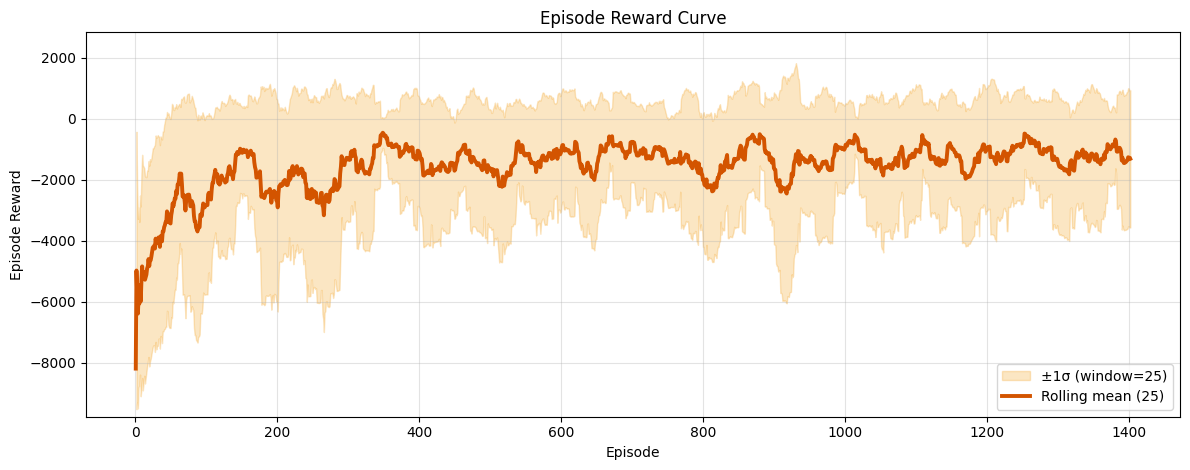

/var/folders/lc/sb990zpd2rbgnqwtz_zn2fqh0000gn/T/ipykernel_34561/2109517416.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = s.groupby("eval_index").apply(lambda g: (g["outcome"] == "goal").mean() * 100.0)


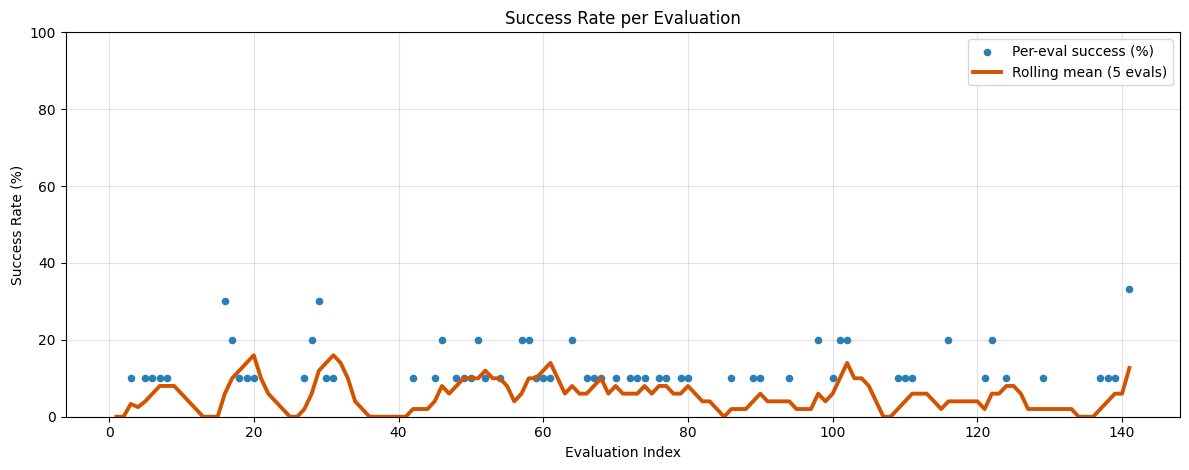

In [2]:
dfm = load_monitor_csv(MONITOR_CSV)
dfm["episode"] = np.arange(1, len(dfm)+1)

win = max(5, int(ROLL_WINDOW_REWARD))
roll_mean = dfm["r"].rolling(window=win, min_periods=1).mean()
roll_std  = dfm["r"].rolling(window=win, min_periods=1).std()

p5, p95 = np.nanpercentile(dfm["r"], [5, 95])
ymin, ymax = float(p5), float(p95)
margin = 0.08 * (ymax - ymin + 1e-9)

plt.figure(figsize=(12,4.8))

plt.fill_between(dfm["episode"], roll_mean - roll_std, roll_mean + roll_std,
                 color="#f39c12", alpha=0.25, label=f"±1σ (window={win})")

plt.plot(dfm["episode"], roll_mean, linewidth=2.8, color="#d35400", label=f"Rolling mean ({win})")

plt.title("Episode Reward Curve")
plt.xlabel("Episode")
plt.ylabel("Episode Reward")
plt.ylim(ymin - margin - 2000, ymax + margin + 2000) 
plt.grid(True, alpha=0.35); plt.legend(frameon=True)
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "episode_reward_curve_consistent.png"), dpi=300)
plt.show()

if EVAL_CSV and os.path.exists(EVAL_CSV):
    dfe = load_eval_csv(EVAL_CSV)
    x = dfe["eval_index"].values
    y = (dfe["success_rate"].values * 100.0)
else:
    s = load_summary_for_proxy(SUMMARY_CSV)
    episodes_per_eval = 10
    s["eval_index"] = ((s["episode"] - 1) // episodes_per_eval) + 1
    tmp = s.groupby("eval_index").apply(lambda g: (g["outcome"] == "goal").mean() * 100.0)
    x = tmp.index.values
    y = tmp.values
    
plt.figure(figsize=(12,4.8))

plt.scatter(x[y>0], y[y>0], s=20, c="#2980b9", label="Per-eval success (%)", zorder=3)
ys = pd.Series(y).rolling(window=SUCCESS_ROLL, min_periods=1).mean()
plt.plot(x, ys, linewidth=2.8, color="#d35400", label=f"Rolling mean ({SUCCESS_ROLL} evals)", zorder=4)

plt.title("Success Rate per Evaluation")
plt.xlabel("Evaluation Index")
plt.ylabel("Success Rate (%)")   
plt.ylim(0, 100)
plt.grid(True, alpha=0.35); plt.legend(frameon=True)
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "success_rate_curve_consistent.png"), dpi=300)
plt.show()

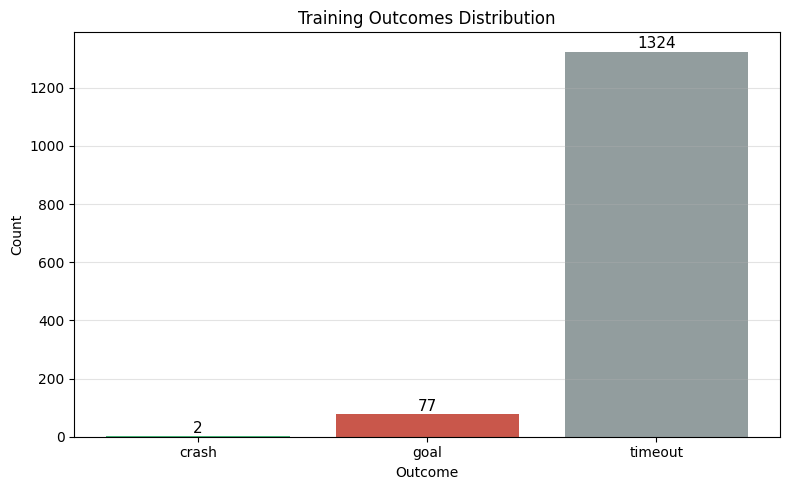

In [3]:
outcome_counts = s["outcome"].value_counts().sort_index()

plt.figure(figsize=(8,5))
bars = plt.bar(outcome_counts.index, outcome_counts.values, color=["#27ae60", "#c0392b", "#7f8c8d"], alpha=0.85)

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 1, f"{int(h)}", ha="center", va="bottom", fontsize=11)

plt.title("Training Outcomes Distribution")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.35)
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "outcome_distribution.png"), dpi=300)
plt.show()

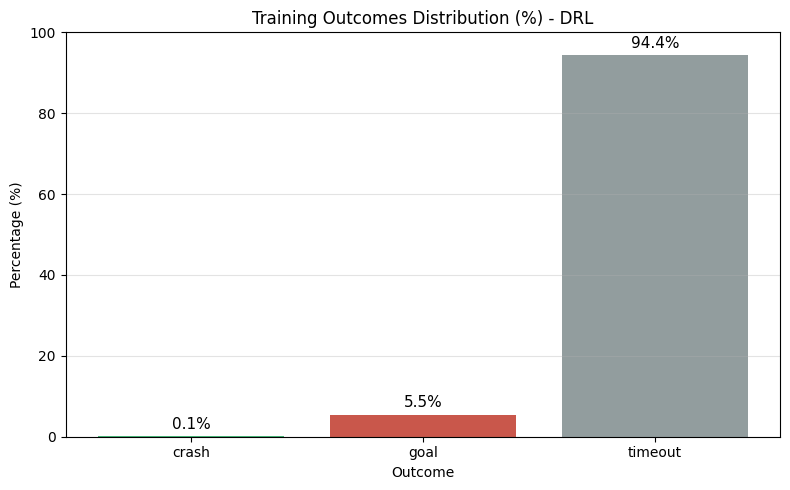

In [4]:
outcome_perc = (outcome_counts / outcome_counts.sum()) * 100

plt.figure(figsize=(8,5))
bars = plt.bar(outcome_perc.index, outcome_perc.values, color=["#27ae60", "#c0392b", "#7f8c8d"], alpha=0.85)

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 1, f"{h:.1f}%", ha="center", va="bottom", fontsize=11)

plt.title("Training Outcomes Distribution (%) - DRL")
plt.xlabel("Outcome")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)
plt.grid(axis="y", alpha=0.35)
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "outcome_distribution_percent.png"), dpi=300)
plt.show()

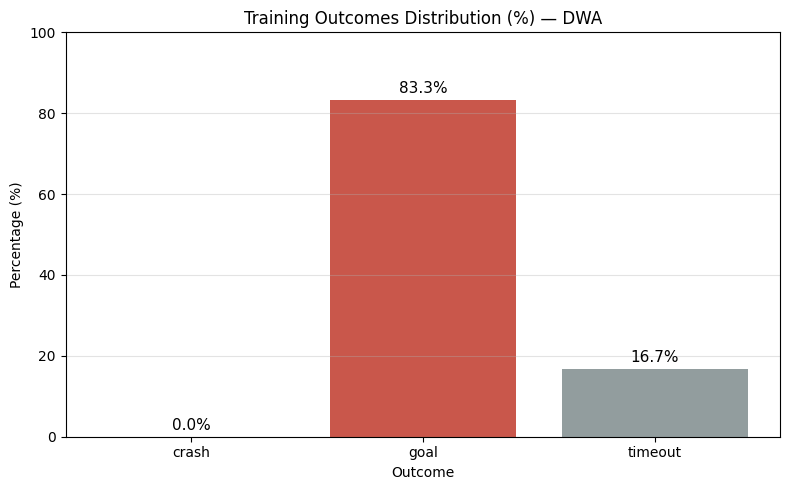

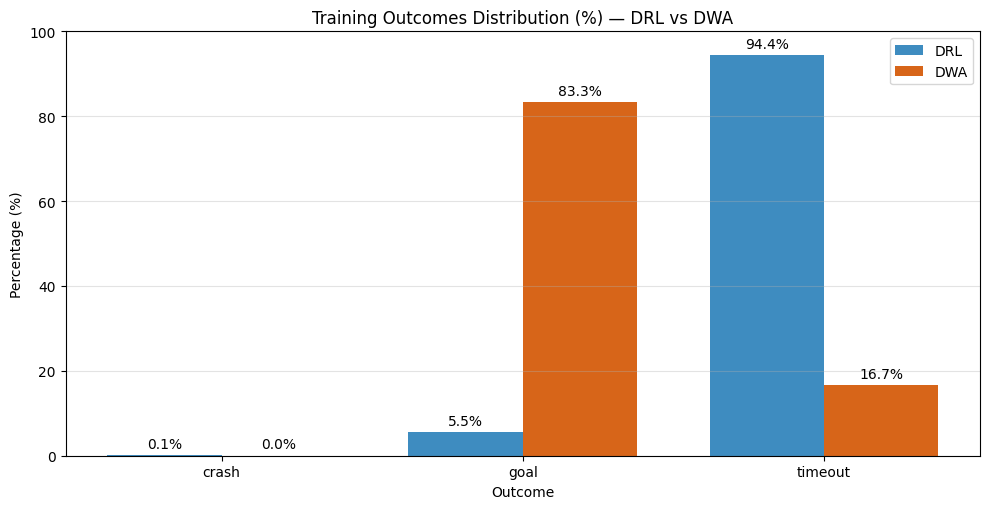

In [5]:
SECOND_SUMMARY_CSV = "dwa_summary.csv"  

def percent_outcomes_flexible(path: str) -> pd.Series:
    df = pd.read_csv(path)
    df.columns = [c.strip().lower() for c in df.columns]

    if "outcome" in df.columns:
        out = df["outcome"].astype(str).str.strip().str.lower()
        out = out.replace({"success": "goal"})
        counts = out.value_counts().sort_index()
        return (counts / counts.sum()) * 100

    s = load_summary_for_proxy(path)
    out = s["outcome"].astype(str).str.strip().str.lower()
    out = out.replace({"success": "goal"})
    counts = out.value_counts().sort_index()
    return (counts / counts.sum()) * 100

outcome_perc_1 = percent_outcomes_flexible(SUMMARY_CSV)       
outcome_perc_2 = percent_outcomes_flexible(SECOND_SUMMARY_CSV) 

all_cats = sorted(set(outcome_perc_1.index).union(set(outcome_perc_2.index)))
p1 = outcome_perc_1.reindex(all_cats, fill_value=0.0)
p2 = outcome_perc_2.reindex(all_cats, fill_value=0.0)

plt.figure(figsize=(8,5))
bars = plt.bar(p2.index, p2.values, color=["#27ae60", "#c0392b", "#7f8c8d"], alpha=0.85)
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 1, f"{h:.1f}%", ha="center", va="bottom", fontsize=11)
plt.title("Training Outcomes Distribution (%) — DWA")
plt.xlabel("Outcome")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)
plt.grid(axis="y", alpha=0.35)
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "outcome_distribution_percent_dwa.png"), dpi=300)
plt.show()

x = np.arange(len(all_cats))
w = 0.38

plt.figure(figsize=(10,5.2))
b1 = plt.bar(x - w/2, p1.values, width=w, label="DRL", color="#2980b9", alpha=0.9)
b2 = plt.bar(x + w/2, p2.values, width=w, label="DWA",   color="#d35400", alpha=0.9)

def annotate_bars(bars):
    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h + 1, f"{h:.1f}%", ha="center", va="bottom", fontsize=10)

annotate_bars(b1)
annotate_bars(b2)

plt.title("Training Outcomes Distribution (%) — DRL vs DWA")
plt.xticks(x, all_cats)
plt.xlabel("Outcome")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)
plt.legend()
plt.grid(axis="y", alpha=0.35)
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "outcome_distribution_percent_comparison_runA_vs_DWA.png"), dpi=300)
plt.show()